In [1]:
%run ../nn_option_pricer/_key_imports.py
import sys

sys.path.append("../")
from nn_option_pricer.bs import make_GBM_dataset

In [2]:
SEED = 42
T = 1
N_TIMES = 1
N_SAMPLES = 2**16
param_space = {"log(S/K)": (0.5, 2), "sigma": (0.2, 3)}


from pandas.util.testing import assert_frame_equal

assert_frame_equal(
    make_GBM_dataset(param_space, N_SAMPLES, N_TIMES, T, seed=42),
    make_GBM_dataset(param_space, N_SAMPLES, N_TIMES, T, seed=42),
)


start = time.time()
X_df = make_GBM_dataset(param_space, N_SAMPLES, N_TIMES, T, seed=42)
print("Dataset Generation Time", time.time() - start)
X_df.to_csv("datasets/bs_train.csv", index=False)

start = time.time()
X_df_test = make_GBM_dataset(param_space, N_SAMPLES, N_TIMES, T, seed=2022)
X_df_test.to_csv("datasets/bs_test.csv", index=False)
print("Dataset Generation Time", time.time() - start)


display(X_df)

(65536, 3) (65536,)
(65536, 3) (65536,)
(65536, 3) (65536,)
Dataset Generation Time 0.19378280639648438
(65536, 3) (65536,)
Dataset Generation Time 0.8940281867980957


,log(S/K),ttm,sigma,pathwise_delta,call_payoff,call_true,digital_payoff,digital_true,true_d_log(S/K),true_d_ttm,true_d2_log(S/K),path
0,0.379784,0.916123,0.916123,3.371760,0.836235,0.699446,1,0.482649,1.182095,0.398565,1.617151,0
1,-0.084732,2.528017,2.528017,0.000000,0.000000,0.721152,0,0.097225,0.818378,0.171920,0.886384,1
2,0.497122,1.981130,1.981130,0.000000,0.000000,1.237969,0,0.229760,1.467729,0.303471,1.620910,2
3,0.273610,2.198720,2.198720,0.000000,0.000000,1.004609,0,0.164800,1.169409,0.248038,1.282220,3
4,-0.562590,1.200531,1.200531,0.000000,0.000000,0.172141,0,0.142561,0.314702,0.225329,0.502393,4
...,...,...,...,...,...,...,...,...,...,...,...,...
65531,-0.022060,0.825162,0.825162,0.000000,0.000000,0.305792,0,0.330217,0.636009,0.362244,1.075006,65531
65532,0.677552,1.371543,1.371543,3.553021,0.884946,1.310683,1,0.423963,1.734647,0.391674,2.020219,65532
65533,-0.378373,2.288323,2.288323,0.000000,0.000000,0.477570,0,0.095181,0.572751,0.169255,0.646716,65533
65534,0.117582,1.417418,1.417418,0.000000,0.000000,0.618021,0,0.265738,0.883759,0.328006,1.115170,65534


Text(0.5, 1.0, 'True payoffs vs Monyness')

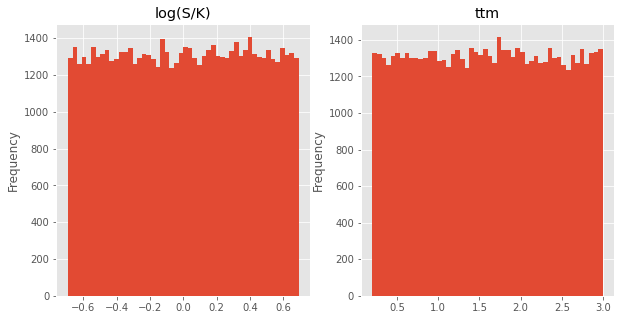

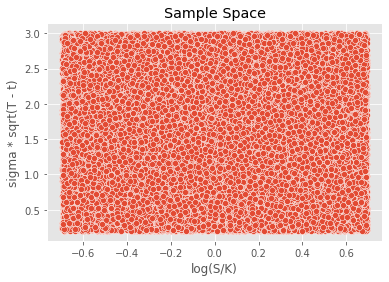

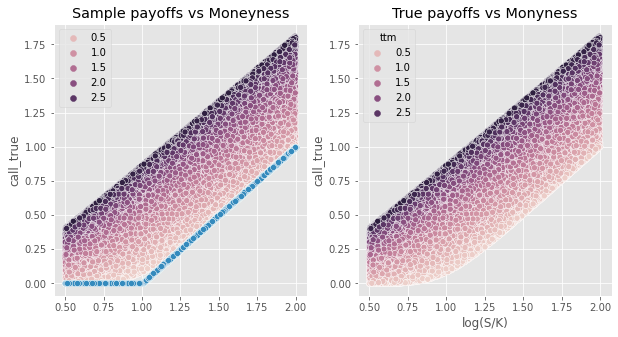

In [3]:
"""
Visualise data
"""
feat_names = ["log(S/K)", "ttm"]
Xs = X_df[feat_names].values
ys = X_df["call_true"]
f_to_i = lambda x: feat_names.index(x)

# Marginal Distributions of Parameter Space
fig, ax = plt.subplots(figsize=(5 * len(feat_names), 5), ncols=len(feat_names))
for i in range(len(feat_names)):
    X_df.iloc[:, i].plot(kind="hist", ax=ax[i], bins=50)
    ax[i].set_title(feat_names[i])
# Terminal Distribution of underlying
fig, ax = plt.subplots()
sns.scatterplot(x=Xs[:, f_to_i("log(S/K)")], y=Xs[:, f_to_i("ttm")], ax=ax)
ax.set_title("Sample Space")
ax.set_xlabel("log(S/K)")
ax.set_ylabel("sigma * sqrt(T - t)")
# sample payoff, intrinsic val v S/K

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
intrinsic_val = np.maximum(np.exp(Xs[:, f_to_i("log(S/K)")]) - 1.0, 0)
sns.scatterplot(
    x=np.exp(Xs[:, f_to_i("log(S/K)")]), y=ys, hue=Xs[:, f_to_i("ttm")], ax=ax[0]
)
sns.scatterplot(x=np.exp(Xs[:, f_to_i("log(S/K)")]), y=intrinsic_val, ax=ax[0])
ax[0].set_title("Sample payoffs vs Moneyness")
sns.scatterplot(
    x=np.exp(X_df["log(S/K)"]), y=X_df["call_true"], hue=X_df["ttm"], ax=ax[1]
)
ax[1].set_title("True payoffs vs Monyness")

In [4]:
from nn_option_pricer.bs import bs_log_pde_err

In [5]:
true_pde_err = bs_log_pde_err(
    X_df["log(S/K)"],
    X_df["ttm"],
    X_df["true_d_ttm"],
    X_df["true_d_log(S/K)"],
    X_df["true_d2_log(S/K)"],
)
assert np.allclose(np.mean(true_pde_err), 0)